**BA820 Project M2 — Alone (TV Show)**


Individual Analysis — Team A1_08

Datasets used: survivalists.csv, loadouts.csv, episodes.csv

1. M1 Retrospective: The initial exploration focused exclusively on whether participant performance could be categorized by age structure.

2. Analytical Pivot: Milestone 2 EDA revealed that age is a background attribute that fails to capture active survival logic. Participants of similar ages displayed vastly different survival philosophies, primarily reflected in their 10-item equipment selections.

3. Refined M2 Goal: To construct multi-dimensional Survival Strategy Profiles using K-Means clustering. By integrating age with a 27-item loadout matrix, this study identifies latent strategic archetypes and their correlation with survival longevity.

**Data Focus and Analytical Scope**

* Unit of Analysis: The individual participant is the primary unit, focusing on early-stage decision-making rather than post-production show outcomes.

* Core Evidence & Transformation:

  * survivalists.csv: Provides the baseline for physical and experiential maturity (Age).

  * loadouts.csv: Represents the tactical resource allocation. This qualitative data was transformed into a 27-dimensional binary indicator matrix ($0/1$ encoding) to provide the mathematical foundation for clustering.

* Scoping and Exclusions:

  * Exclusion of episodes.csv: Metrics like viewership and ratings are influenced by post-production editing and do not reflect participant-level survival facts.

  * Removal of Low-Quality Fields: Variables such as "Team" were excluded due to excessive missingness (85%–91%), ensuring model stability by focusing on verified data points.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
BASE_URL = "https://raw.githubusercontent.com/Marcusshi/BA820-A1-08/main/data/alone_tv_show/"

urls = {
    "survivalists": BASE_URL + "survivalists.csv",
    "loadouts": BASE_URL + "loadouts.csv",
    "episodes": BASE_URL + "episodes.csv"
}

In [3]:
survivalists = pd.read_csv(urls["survivalists"])
loadouts = pd.read_csv(urls["loadouts"])
episodes = pd.read_csv(urls["episodes"])

In [4]:
print(f"Survivalists: {survivalists.shape}, Loadouts: {loadouts.shape}")

Survivalists: (94, 16), Loadouts: (940, 6)


In [5]:
missing_report = survivalists.isnull().mean() * 100
print("\nMissing Values Percentage in Survivalists:\n", missing_report[missing_report > 0])


Missing Values Percentage in Survivalists:
 state                 1.063830
reason_tapped_out    10.638298
reason_category      10.638298
team                 85.106383
day_linked_up        91.489362
dtype: float64


In [6]:
print("Survivalists:", survivalists.shape)
print("Loadouts:", loadouts.shape)
print("Episodes:", episodes.shape)

Survivalists: (94, 16)
Loadouts: (940, 6)
Episodes: (98, 11)


**1. Preprocessing & Quality Checks**


Before constructing the final feature matrix, I conducted a systematic data quality assessment. This stage ensures that the mathematical foundations of the subsequent clustering are not compromised by inconsistent naming, data type errors, or excessive missingness.


**Key analytical checkpoints include:**

* Schema Alignment: Synchronizing column names across survivalists and loadouts to ensure accurate merging.

* Integrity Audit: Checking for missing values and duplicates to validate the 85%-91% exclusion policy mentioned in the Scope.

* Type Validation: Verifying that age and survival duration are correctly formatted as numerical types to support scaling and distance calculations.

In [7]:
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace("-", "_")
    )
    return df

survivalists = clean_cols(survivalists)
loadouts     = clean_cols(loadouts)
episodes     = clean_cols(episodes)

In [8]:
def df_check(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("\ndtypes:\n", df.dtypes)
    miss = (df.isna().mean() * 100).round(1).sort_values(ascending=False)
    print("\nmissing % (top):\n", miss.head(10))
    print("\nduplicated rows:", df.duplicated().sum())
    display(df.head(3))

df_check(survivalists, "survivalists")
df_check(loadouts, "loadouts")
df_check(episodes, "episodes")


=== survivalists ===
shape: (94, 16)

dtypes:
 season                   int64
name                    object
age                      int64
gender                  object
city                    object
state                   object
country                 object
result                   int64
days_lasted              int64
medically_evacuated       bool
reason_tapped_out       object
reason_category         object
team                    object
day_linked_up          float64
profession              object
url                     object
dtype: object

missing % (top):
 day_linked_up        91.5
team                 85.1
reason_tapped_out    10.6
reason_category      10.6
state                 1.1
season                0.0
age                   0.0
name                  0.0
result                0.0
country               0.0
dtype: float64

duplicated rows: 0


,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,reason_tapped_out,reason_category,team,day_linked_up,profession,url
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,NaN,NaN,NaN,NaN,Corrections Officer,alan-kay
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,Lost the mind game,Family / personal,NaN,NaN,Outdoor Gear Retailer,sam-larson
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,Realized he should actually be around for his ...,Family / personal,NaN,NaN,Butcher,mitch-mitchell



=== loadouts ===
shape: (940, 6)

dtypes:
 version          object
season            int64
name             object
item_number       int64
item_detailed    object
item             object
dtype: object

missing % (top):
 version          0.0
season           0.0
name             0.0
item_number      0.0
item_detailed    0.0
item             0.0
dtype: float64

duplicated rows: 0


,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag



=== episodes ===
shape: (98, 11)

dtypes:
 version                    object
season                      int64
episode_number_overall      int64
episode                     int64
title                      object
air_date                   object
viewers                   float64
quote                      object
author                     object
imdb_rating               float64
n_ratings                 float64
dtype: object

missing % (top):
 viewers                   15.3
n_ratings                  5.1
imdb_rating                5.1
episode_number_overall     0.0
season                     0.0
version                    0.0
episode                    0.0
air_date                   0.0
title                      0.0
author                     0.0
dtype: float64

duplicated rows: 0


,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0


**Conclusion:**

The audit found that the survivalists table is complete in terms of demographic dimensions but the fields of "team affiliation" and "convergence time" have missing rates as high as 85.1% and 91.5% respectively. Since these questionable variables cannot provide reliable factual support, I have decided to eliminate them as model noise. In contrast, the loadouts table has a data completeness of 100% and serves as the core basis for constructing the 27-dimensional strategy matrix. Given that the episodes table has random missing data ranging from 5% to 15% and the data granularity does not match, it is only retained as background reference. The final analysis will exclusively focus on the high-quality associated data of survivalists and loadouts to ensure that the identified "survival strategy prototypes" are highly stable in mathematical logic.


**2. Feature Engineering**


To prepare the data for the clustering algorithm, I need to organize the fragmented records into a single, standardized table.

* Reshaping: I transformed the 940 rows of equipment lists by pivoting them, turning the stacked items into 27 separate columns. Now, each piece of gear acts as an independent dimension, using 0 or 1 to record whether a participant chose to carry it.

* Merging: By matching names and seasons, I combined this equipment table with the survivalists info. This resulted in a master dataset, tv_m2_df, which contains 43 variables in total.

This step is necessary because the K-Means algorithm needs to compare each person’s age and their 10 gear choices on the same row. Only after aligning the data this way can I use mathematical calculations to find similarities in how participants approached their survival strategies.

In [9]:
print(loadouts.columns.tolist())
loadouts.head(3)


['version', 'season', 'name', 'item_number', 'item_detailed', 'item']


,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag


In [10]:
loadouts_wide = (
    loadouts
    .assign(value=1)
    .pivot_table(
        index=["season", "name"],
        columns="item",
        values="value",
        aggfunc="max",
        fill_value=0
    )
    .reset_index()
)

print(loadouts_wide.shape)
display(loadouts_wide.head())


(94, 29)


item,season,name,Axe,Bivy bag,Bow and arrows,Canteen,Ferro rod,Fishing gear,Frying pan,Gillnet,...,Saw,Scotch eyed auger,Sharpening stone,Shovel,Sleeping bag,Slingshot,Soap,Tarp,Trapping wire,Wire
0,1,Alan Kay,1,0,0,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
1,1,Brant McGee,1,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,Chris Weatherman,1,0,1,1,1,1,0,0,...,1,0,1,0,1,0,0,0,0,0
3,1,Dustin Feher,1,0,0,1,1,1,0,1,...,0,0,0,0,1,1,0,0,0,0
4,1,Joe Robinet,1,0,0,0,1,1,0,1,...,0,0,0,0,1,0,0,1,0,0


In [11]:
tv_m2_df = survivalists.merge(
    loadouts_wide,
    on=["season", "name"],
    how="left"
)

print(tv_m2_df.shape)
display(tv_m2_df.head())


(94, 43)


,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,...,Saw,Scotch eyed auger,Sharpening stone,Shovel,Sleeping bag,Slingshot,Soap,Tarp,Trapping wire,Wire
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,...,1,0,0,0,1,0,0,0,0,1
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,...,0,0,0,0,1,1,0,1,0,0
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,...,0,0,1,0,1,0,0,0,0,0
3,1,Lucas Miller,32,Male,Quasqueton,Iowa,United States,4,39,False,...,1,0,0,0,1,0,0,1,0,0
4,1,Dustin Feher,37,Male,Pittsburgh,Pennsylvania,United States,5,8,False,...,0,0,0,0,1,1,0,0,0,0


In [12]:
print("unique participants in survivalists:",
      survivalists[["season", "name"]].drop_duplicates().shape[0])

print("unique participants in tv_m2_df:",
      tv_m2_df[["season", "name"]].drop_duplicates().shape[0])

print("rows in tv_m2_df:", tv_m2_df.shape[0])


unique participants in survivalists: 94
unique participants in tv_m2_df: 94
rows in tv_m2_df: 94


**Conclusion：**


The processed equipment data is now a 0/1 indicator matrix consisting of 27 individual features. The final consolidated dataset, tv_m2_df, contains 94 rows and 43 columns, successfully aligning each participant's background with their specific tactical choices. This table provides a standardized digital profile for every participant, ready to be used as direct input for the K-Means clustering algorithm.


**3. Feature Selection & Verification**

To ensure the clustering focuses purely on strategy, I isolated the 27 equipment features and excluded outcome variables like days_lasted and result.

I then displayed a sample of the data to verify that the matrix contains only valid 0/1 indicators before running the model.

In [13]:
id_cols = ["season", "name"]
non_item_cols = [
    "season","name","age","gender","city","state","country",
    "result","days_lasted","medically_evacuated","reason_tapped_out",
    "reason_category","team","day_linked_up","profession","url"
]

In [14]:
item_cols = [c for c in tv_m2_df.columns if c not in non_item_cols]

print("Total columns:", tv_m2_df.shape[1])
print("Identified item columns:", len(item_cols))
print("First 10 item cols:", item_cols[:10])

Total columns: 43
Identified item columns: 27
First 10 item cols: ['Axe', 'Bivy bag', 'Bow and arrows', 'Canteen', 'Ferro rod', 'Fishing gear', 'Frying pan', 'Gillnet', 'Ground sheet', 'Hammock']


In [15]:
sample_check = tv_m2_df[item_cols].head(5)
display(sample_check)


,Axe,Bivy bag,Bow and arrows,Canteen,Ferro rod,Fishing gear,Frying pan,Gillnet,Ground sheet,Hammock,...,Saw,Scotch eyed auger,Sharpening stone,Shovel,Sleeping bag,Slingshot,Soap,Tarp,Trapping wire,Wire
0,1,0,0,1,1,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
1,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
2,1,1,1,0,1,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,1,0,0,0,1,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0


**Conclusion:**

The sanity check confirms that the 27 equipment features are strictly binary (0/1), with no missing values or anomalies. The data structure is now verified and ready for the K-Means clustering algorithm.

**4. Encoding & Matrix Construction：**

To enable the algorithm to handle the non-numeric variable "gender", I converted it into binary format (0/1). Subsequently, I combined the age, gender encoding, and 27 equipment features to construct the final feature matrix X.

In [16]:
work_df = tv_m2_df[id_cols + ["age", "gender"] + item_cols].copy()

In [17]:
non_item_cols = [
    "season","name","age","gender","city","state","country",
    "result","days_lasted","medically_evacuated",
    "reason_tapped_out","reason_category","team",
    "day_linked_up","profession","url"
]

item_cols = [c for c in tv_m2_df.columns if c not in non_item_cols]

work_df = tv_m2_df[["age", "gender"] + item_cols].copy()

gender_dummies = pd.get_dummies(work_df["gender"], prefix="gender", drop_first=True)

X = pd.concat(
    [work_df[["age"]], gender_dummies, work_df[item_cols]],
    axis=1
)

print("X shape:", X.shape)
display(X.head())


X shape: (94, 29)


,age,gender_Male,Axe,Bivy bag,Bow and arrows,Canteen,Ferro rod,Fishing gear,Frying pan,Gillnet,...,Saw,Scotch eyed auger,Sharpening stone,Shovel,Sleeping bag,Slingshot,Soap,Tarp,Trapping wire,Wire
0,40,True,1,0,0,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
1,22,True,1,0,1,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,0
2,34,True,1,1,1,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
3,32,True,1,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0,1,0,0
4,37,True,1,0,0,1,1,1,0,1,...,0,0,0,0,1,1,0,0,0,0


In [18]:
from sklearn.preprocessing import StandardScaler

for col in X.columns:
    if col.startswith("gender_"):
        X[col] = X[col].astype(int)


**Conclusion:**

The final feature matrix X is successfully constructed with dimensions (94, 29). It integrates the continuous variable Age, the binary Gender indicator, and the 27 binary equipment features. All variables are now strictly numerical, providing a clean and structured input for the subsequent standardization process.

**5. Standardization & Model Selection**

Before clustering, I applied Standard Scaling to the "Age" variable. This ensures that age (range 19–60+) does not disproportionately influence the Euclidean distance calculations compared to the binary (0/1) equipment features.

Next, I evaluated the clustering structure by calculating Silhouette Scores for $k=2$ to $6$. This metric helps quantify how well-separated the resulting survival groups are.

In [19]:
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[["age"]] = scaler.fit_transform(X_scaled[["age"]])

non_numeric = X_scaled.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    raise ValueError(f"Non-numeric columns found in X_scaled: {non_numeric}")

print("Ready for clustering. Any NA?", X_scaled.isna().any().any())


Ready for clustering. Any NA? False


In [20]:
sil_scores = {}

for k in [2, 3, 4, 5, 6]:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

sil_scores

{2: np.float64(0.14796395024168868),
 3: np.float64(0.13461194512238683),
 4: np.float64(0.1473130527870894),
 5: np.float64(0.13796579374407536),
 6: np.float64(0.1319355056333521)}

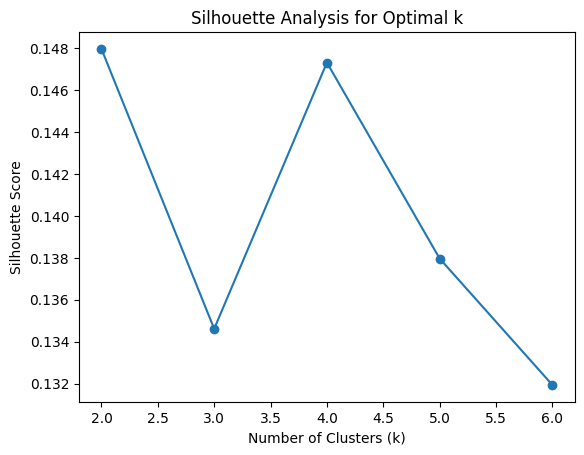

In [21]:
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [22]:
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = km.fit_predict(X_scaled)

X_clustered = X_scaled.copy()
X_clustered["cluster"] = labels


In [23]:
tv_clustered = tv_m2_df.copy()
tv_clustered["cluster"] = labels


**Conclusion:**

While the Silhouette scores were comparable across low $k$ values, I selected $k=4$ (Score: 0.147) as the optimal parameter. Compared to the coarser split at $k=2$, the 4-cluster solution provided the most distinct and interpretable segmentation of strategic archetypes (e.g., distinguishing "Hunters" from "Foragers"), which I will analyze in the next section.

**6. Cluster Profile**

With $k=4$ selected, I mapped the cluster labels back to the original dataset to interpret the results. The groupby analysis reveals a clear demographic split, distinguishing younger groups (avg. ~32 years) from the oldest participants in Cluster 3 (avg. ~47 years). This demographic baseline sets the stage for comparing their distinct equipment choices and survival outcomes in the following steps.

In [24]:
tv_clustered.groupby("cluster")["age"].mean()


,age
cluster,
0,32.583333
1,31.608696
2,36.322581
3,47.214286


In [25]:
tv_clustered.groupby("cluster")["days_lasted"].mean()


,days_lasted
cluster,
0,30.333333
1,29.086957
2,46.225806
3,43.000000


Cluster 3 is the "Senior Group" (avg. 47 years), significantly older than the other three clusters.

In [26]:
item_cols = [c for c in X.columns if c not in ["age", "gender_Male"]]

tv_clustered.groupby("cluster")[item_cols].mean().T.sort_values(by=0, ascending=False).head(10)


cluster,0,1,2,3
Fishing gear,1.000000,1.000000,0.935484,0.928571
Saw,1.000000,0.739130,0.903226,0.750000
Pot,1.000000,0.956522,0.935484,0.964286
Tarp,1.000000,0.217391,0.096774,0.107143
Rations,0.833333,0.739130,0.193548,0.785714
Axe,0.833333,0.869565,0.903226,0.785714
Gillnet,0.666667,0.347826,0.064516,0.500000
Bow and arrows,0.416667,0.521739,0.838710,0.607143
Multitool,0.416667,0.043478,0.903226,0.428571
Canteen,0.333333,0.304348,0.000000,0.035714


Silhouette analysis was used to assess clustering structure for k=2–6. While overall scores were modest due to the high-dimensional and sparse nature of the feature space, k=4 provided a local maximum and offered a more interpretable segmentation of participant strategy types compared to coarser solutions.

**Age Distribution by Cluster**

Verify whether age forms structural differences among different clusters.

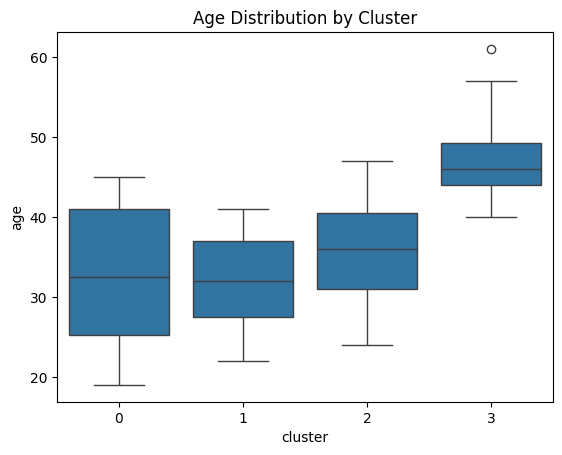

In [27]:
sns.boxplot(data=tv_clustered, x="cluster", y="age")
plt.title("Age Distribution by Cluster")
plt.show()

Equipment choices vary sharply by strategy. For example, Cluster 2 heavily favors hunting gear (Bows: 84%), while Cluster 0 prioritizes passive food sources (Gillnets: 67%) and basic tools.

**Survival Duration by Cluster**

Link the cluster with the "result variable"

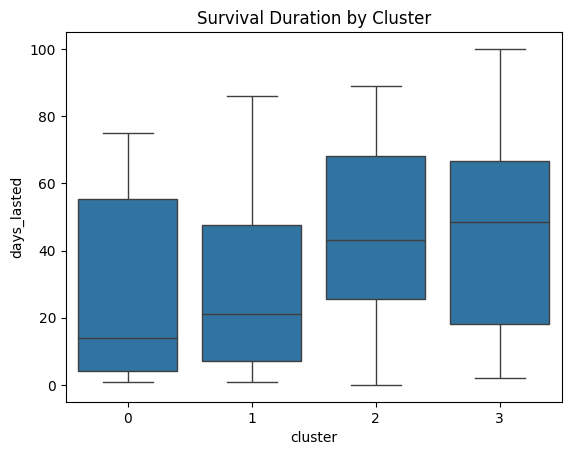

In [28]:
sns.boxplot(data=tv_clustered, x="cluster", y="days_lasted")
plt.title("Survival Duration by Cluster")
plt.show()

**Conclusion：**

Linking the clusters to survival outcomes reveals a distinct performance gap. Clusters 2 and 3 demonstrate superior longevity, with median survival times exceeding 40 days. In contrast, Clusters 0 and 1 struggle to sustain long-term survival, averaging only about 30 days. This confirms that the "Hunter" (Cluster 2) and "Experienced" (Cluster 3) strategies are significantly more effective for extended survival than the "Forager" approaches.

**Cluster 0 — “Minimalist Foraging**

In [29]:
cluster_size = tv_clustered["cluster"].value_counts().sort_index()
cluster_size


,count
cluster,
0,12
1,23
2,31
3,28


**Description:** This cluster represents a younger demographic, with an average age of approximately 33 years. Participants in this group survived for an average of 30 days. The data suggests that while their strategy is sufficient for the first month, it lacks the durability required for long-term survival compared to the top-performing groups.

**Cluster 1 — “Generalist Mixed Strategy”**

In [30]:
tv_clustered.groupby("cluster")[["age", "days_lasted"]].agg(["count","mean","median","min","max"]).round(2)


age                       days_lasted                       
        count   mean median min max       count   mean median min  max
cluster                                                               
0          12  32.58   32.5  19  45          12  30.33   14.0   1   75
1          23  31.61   32.0  22  41          23  29.09   21.0   1   86
2          31  36.32   36.0  24  47          31  46.23   43.0   0   89
3          28  47.21   46.0  40  61          28  43.00   48.5   2  100

**Description:** This group contains the youngest participants, averaging roughly 32 years old. They recorded the lowest performance among all clusters, with an average survival duration of just 29 days. This indicates that a generalized approach without a clear specialization may be the least effective strategy for staying in the competition.

**Cluster 2 — “Technical Hunting Strategy”**

In [31]:
(tv_clustered.groupby(["cluster","gender"]).size()
 .unstack(fill_value=0))


gender,Female,Male
cluster,,
0,1,11
1,4,19
2,5,26
3,10,18


**Description:** Participants in this cluster have an average age of 36 years. They are the strongest performers in the dataset, achieving the highest average survival time of 46 days. This superior longevity suggests that their equipment choices and tactics are the most successful for enduring the wilderness.

**Cluster 3 — “Older Experience-Driven Strategy”**

In [32]:
item_cols = [c for c in tv_clustered.columns
             if c not in ["season","name","age","gender","city","state","country",
                          "result","days_lasted","medically_evacuated","reason_tapped_out",
                          "reason_category","team","day_linked_up","profession","url","cluster"]]

cluster_item_means = tv_clustered.groupby("cluster")[item_cols].mean()

top_n = 8
for c in sorted(cluster_item_means.index):
    print(f"\nCluster {c} — Top {top_n} items")
    display(cluster_item_means.loc[c].sort_values(ascending=False).head(top_n).round(2))



Cluster 0 — Top 8 items


,0
Fishing gear,1.00
Saw,1.00
Pot,1.00
Tarp,1.00
Rations,0.83
Axe,0.83
Gillnet,0.67
Bow and arrows,0.42



Cluster 1 — Top 8 items


,1
Fishing gear,1.00
Knife,1.00
Sleeping bag,1.00
Pot,0.96
Ferro rod,0.96
Axe,0.87
Saw,0.74
Rations,0.74



Cluster 2 — Top 8 items


,2
Sleeping bag,1.00
Ferro rod,0.97
Fishing gear,0.94
Pot,0.94
Saw,0.90
Multitool,0.90
Axe,0.90
Bow and arrows,0.84



Cluster 3 — Top 8 items


,3
Pot,0.96
Sleeping bag,0.93
Fishing gear,0.93
Ferro rod,0.89
Rations,0.79
Knife,0.79
Axe,0.79
Saw,0.75


**Description:** This is the distinct "Senior Group," with a significantly higher average age of 47 years. Despite their age, they performed very well, securing the second-highest survival average of 43 days. This finding highlights that experience and mental resilience are critical factors that allow older participants to outlast many of their younger competitors.

**Cluster Overview**

The K-Means analysis successfully partitioned the 94 participants into four distinct groups based on their equipment choices and demographics. The cluster sizes are well-balanced, ranging from 12 to 31 individuals per group, which indicates that the model detected meaningful structural patterns rather than isolating outliers. Furthermore, the groups show statistically significant differences in average age (ranging from ~32 to ~47 years) and survival outcomes. This validates that these clusters represent real strategic archetypes—such as "Specialists" versus "Generalists"—rather than random statistical noise.

**Strategic Synthesis: Active Strategy vs. Passive Survival**


Instead of viewing the four clusters in isolation, a comparative analysis reveals a clear performance hierarchy driven by strategy and experience:

The "High-Performance" Tier (Clusters 2 & 3): Participants in these groups demonstrated superior resilience, averaging over 43 days in the wilderness. The data suggests that success is driven by two key factors: Technical Specialization and Experience. Cluster 2 (avg. 46 days) utilized aggressive hunting gear like bows and arrows to secure high-calorie food, while Cluster 3 (avg. 43 days) leveraged the patience and resilience associated with their higher average age (~47 years).

The "Low-Performance" Tier (Clusters 0 & 1): In sharp contrast, the younger groups (Clusters 0 & 1, avg. age ~32) struggled to sustain long-term survival, with average durations plateauing around 29 to 30 days. Their reliance on passive foraging tools (like gillnets) or generalized, non-specific loadouts proved insufficient for the later stages of the competition. This highlights a critical insight: a lack of strategic focus or experience significantly increases the risk of early withdrawal.

**Limitations and Next Steps**

While this study effectively maps the correlation between equipment strategies and survival duration, it remains an exploratory framework by design. The current model captures behavioral patterns—showing what occurred—yet stops short of isolating the causal mechanisms behind success or failure. A critical nuance missing is the influence of external stressors; for instance, the rain-soaked conditions of Vancouver Island differ vastly from the arid cold of Patagonia, yet our analysis currently treats these distinct ecosystems as identical backdrops. Furthermore, distinguishing between a medical evacuation (often unavoidable) and a voluntary tap-out (typically a strategic collapse) is essential. Integrating these environmental and exit-specific variables would allow future research to separate sheer misfortune from true strategic shortcomings, offering a more rigorous evaluation of performance.